In [30]:
from __future__ import division
%matplotlib inline
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from model_fit import *

In [31]:
model = 'gaussian'

In [32]:
#frqs, T_sky, sigma = np.loadtxt('dataset8.txt', unpack = True)

In [33]:
frqs, T_sky = np.loadtxt('scihi_fore.txt', unpack=True)

In [34]:
sigma = radiometer(T_sky, 0.83, np.diff(frqs)[0])

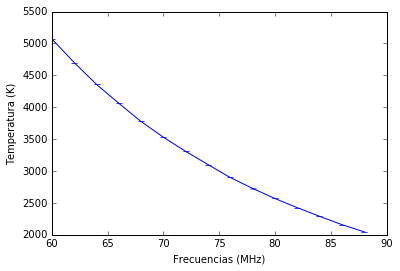

In [35]:
plt.figure()
plt.errorbar(frqs,T_sky,yerr = sigma)
plt.xlabel('Frecuencias (MHz)')
plt.ylabel('Temperatura (K)')

In [36]:
print max(frqs), min(frqs)

88.0089 60.0


In [37]:
priors_gauss = np.array([0.,1000., min(frqs),max(frqs), 0.,40., 0.,10., -10.,0., -1.,1.])

In [38]:
ndim = int(np.size(priors_gauss)/2)

In [39]:
print ndim

6


In [40]:
mid = np.zeros(ndim)

In [41]:
for i in range(ndim):
    mid[i] = priors_gauss[2*i] + priors_gauss[2*i + 1]

In [42]:
mid = 0.5 * mid

In [43]:
fun = lambda *args: -lnhood(*args)

In [62]:
result = op.minimize(fun, mid, args=(model, T_sky, frqs, sigma), method = 'L-BFGS-B')

In [63]:
print result.x

[  4.99999981e+02   7.40042848e+01   1.99998657e+01   7.85207084e+00
  -2.39044365e+00  -8.85037717e-02]


In [64]:
fore=foreground(frqs)

In [65]:
T_gx = fore(result.x[3],result.x[4],result.x[5])

In [66]:
t_b = (T_sky - T_gx) * 1e3

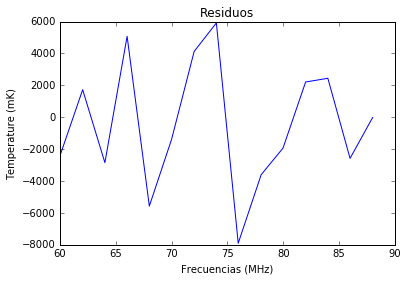

In [70]:
plt.figure()
plt.plot(frqs, t_b)
plt.title('Residuos')
plt.xlabel('Frecuencias (MHz)')
plt.ylabel('Temperature (mK)')

In [71]:
nwalkers = 200

In [72]:
z = np.zeros((ndim, nwalkers))

In [73]:
h = 1e-2

In [74]:
pos_i=[]

In [75]:
np.random.seed(0)

In [76]:
for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.rand(nwalkers)

In [77]:
for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],z[5,i]]))

In [78]:
b_steps,  steps = 500, 1000

In [79]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model, T_sky, frqs, sigma, priors_gauss,0.0))

In [80]:
pos, prob, state = sampler.run_mcmc(pos_i, b_steps)

In [81]:
sampler.reset()

In [82]:
_, _, _ = sampler.run_mcmc(pos, steps, rstate0=state)

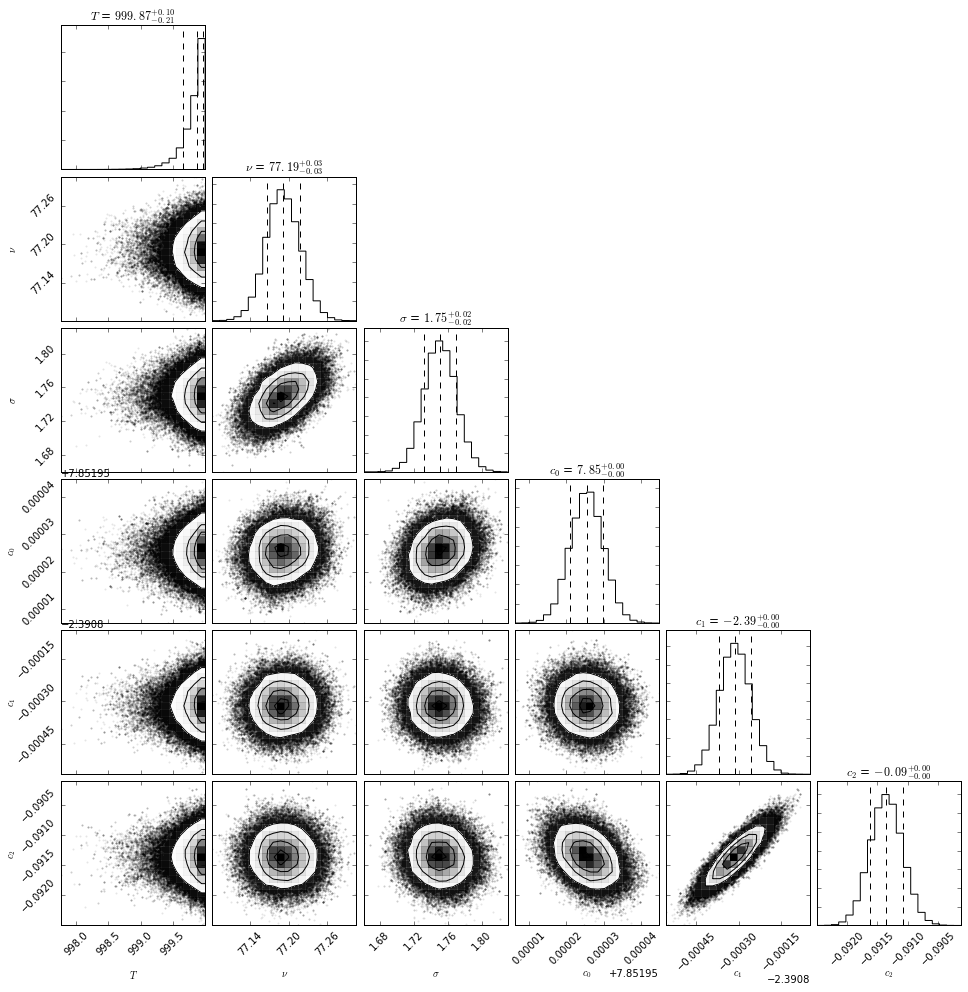

In [84]:
fig = corner.corner(sampler.flatchain, labels = ['$T$',r'$\nu$',r'$\sigma$',r'$c_0$',r'$c_1$',r'$c_2$'] ,quantiles=[0.16, 0.5, 0.84],show_titles=True );

In [85]:
fig.savefig('mcmc_sci_plot.pdf')

In [86]:
np.savetxt('mcmc_sci_plot.txt', sampler.flatchain)

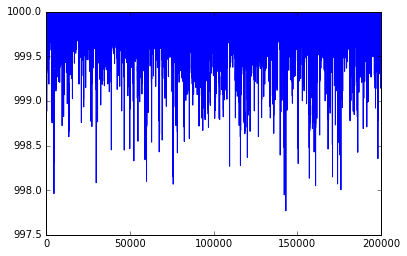

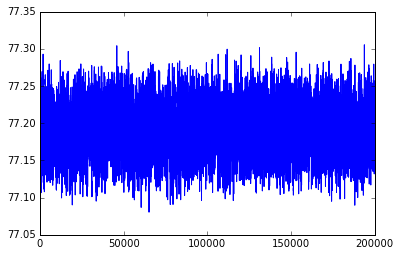

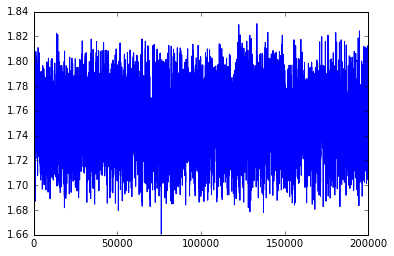

In [87]:
plt.figure()
plt.plot(sampler.flatchain[:,0])
plt.figure()
plt.plot(sampler.flatchain[:,1])
plt.figure()
plt.plot(sampler.flatchain[:,2])

In [88]:
t_corr = np.zeros((nwalkers,steps))                
nu_corr = np.zeros((nwalkers,steps)) 
s_corr = np.zeros((nwalkers,steps)) 

In [89]:
for i in range(nwalkers):
    t_corr[i] = emcee.autocorr.function(sampler.chain[i,:,0],axis=0)
    nu_corr[i] = emcee.autocorr.function(sampler.chain[i,:,1],axis=0)
    s_corr[i] = emcee.autocorr.function(sampler.chain[i,:,2],axis=0)

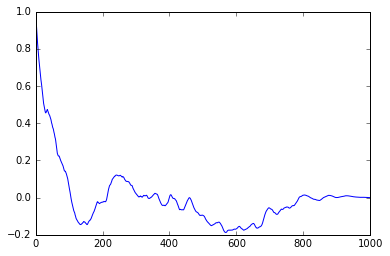

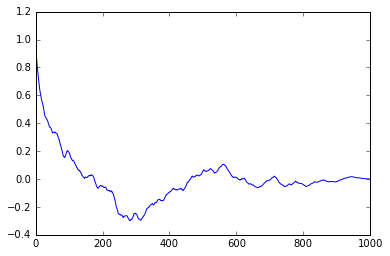

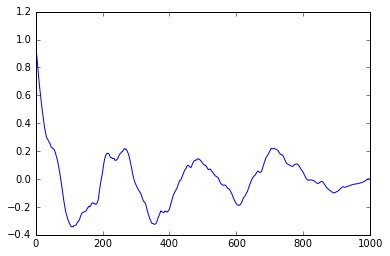

In [90]:
number = 60
plt.figure()
plt.plot(t_corr[number][:])
plt.figure()
plt.plot(nu_corr[number][:])
plt.figure()
plt.plot(s_corr[number][:])

In [94]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model, T_sky, frqs, sigma, priors_gauss,0.0))

In [95]:
sampler2.run_mcmc(pos_i, steps);

(array([[  9.99776133e+02,   7.71908195e+01,   1.71496849e+00,
           7.85197105e+00,  -2.39101104e+00,  -9.07930322e-02],
        [  9.99519680e+02,   7.71846550e+01,   1.74549869e+00,
           7.85197510e+00,  -2.39109590e+00,  -9.13803035e-02],
        [  9.99736171e+02,   7.71885991e+01,   1.75277680e+00,
           7.85196911e+00,  -2.39118657e+00,  -9.16961862e-02],
        ..., 
        [  9.99714885e+02,   7.71660318e+01,   1.75272648e+00,
           7.85197502e+00,  -2.39114914e+00,  -9.16173311e-02],
        [  9.99907122e+02,   7.71726109e+01,   1.75278541e+00,
           7.85197693e+00,  -2.39103809e+00,  -9.10726600e-02],
        [  9.99870853e+02,   7.72174679e+01,   1.77667304e+00,
           7.85198805e+00,  -2.39108057e+00,  -9.15065114e-02]]),
 array([-62831.44138635, -62829.21337444, -62830.84233643, -62832.61434727,
        -62828.15169763, -62828.46823121, -62828.63597744, -62829.74621247,
        -62829.17216532, -62829.23970845, -62827.35217488, -62829.0831

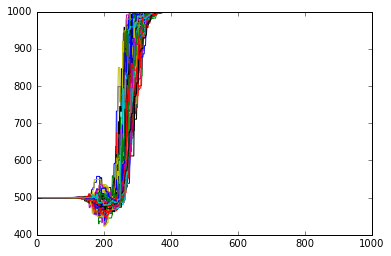

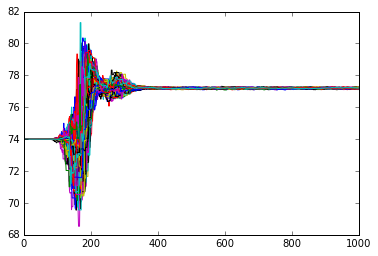

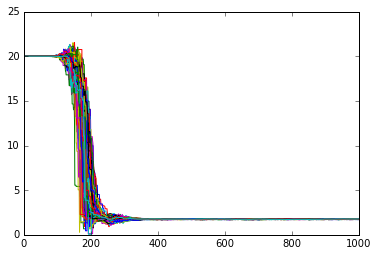

In [96]:
plt.figure()
plt.plot(sampler2.chain[:,:,0].T);
plt.figure()
plt.plot(sampler2.chain[:,:,1].T);
plt.figure()
plt.plot(sampler2.chain[:,:,2].T);

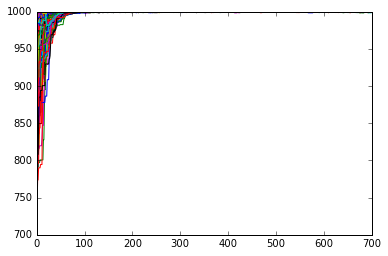

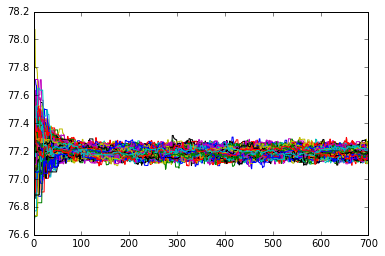

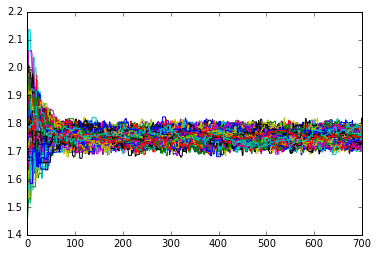

In [99]:
plt.figure()
plt.plot(sampler2.chain[:,300:,0].T);
plt.figure()
plt.plot(sampler2.chain[:,300:,1].T);
plt.figure()
plt.plot(sampler2.chain[:,300:,2].T);

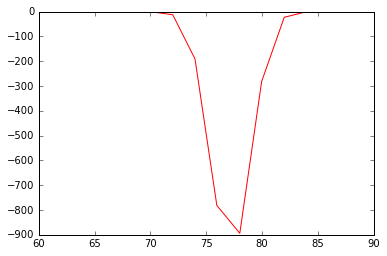

In [103]:
signal = model_21cm(frqs, model)
mean_t = np.mean(sampler.flatchain[:,0])
mean_n = np.mean(sampler.flatchain[:,1])
mean_s = np.mean(sampler.flatchain[:,2])
plt.plot(frqs, signal(mean_t, mean_n, mean_s), 'r')

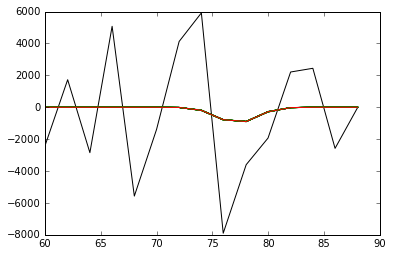

In [111]:
plt.figure()
plt.plot(frqs, t_b, 'k')
for t, n, s, c1,c2,c3 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=50)]:
    plt.plot(frqs,signal(t,n,s), 'g', alpha=0.35)

mean_t = np.mean(sampler.flatchain[:,0])
mean_n = np.mean(sampler.flatchain[:,1])
mean_s = np.mean(sampler.flatchain[:,2])
plt.plot(frqs, signal(mean_t, mean_n, mean_s), 'r')

